# Milestone 1 - SECOM Manufacturing

## Author - Lukas Fiorio

## Instructions

- Prepare a DFD (Data Flow Diagram)
- Read and merge data
- Clean and prepare data 
- Visually explore data
- Handle class imbalance problem
- Apply feature selection techniques to reduce dimensionality of data
- Summarize/describe initial findings

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import urllib

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.feature_selection import mutual_info_regression
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
# set package options
pd.set_option('display.max_columns', None) # show all columns

## Read and merge data

In [3]:
# data sources, for loading
features_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom.data"
labels_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/secom/secom_labels.data"

Inspection shows the features are stored in a space-delimited txt file.  We can read them as-is and store them in a data frame

In [4]:
# load features into df
features = np.loadtxt(features_url)
features_df = pd.DataFrame(features)

The labels are a bit trickier with `"`'s and spaces separating the target and timestamp.  We'll read the data in line, by line.  Looping through we'll remove the `"` and split on space, storing in a list.

In [5]:
# load labels data into list
labels_txt = urllib.request.urlopen(labels_url).read().splitlines()
labels = [] # empty list to store labels

# loop through each row
# convert from byte to string; remove "; and split on ' '
for i in labels_txt:
    i = i.decode("utf-8").replace('"', '').split()
    labels.append(i) # append to list

With labels in a list, we move them into a dataframe, explicitly setting types for the `date` and `time` fields.

In [6]:
# convert labels data to df
labels_df = pd.DataFrame(labels, columns = ['target', 'date', 'time'])

# properly type each column
labels_df['target'] = labels_df['target'].astype('int')
labels_df['date'] = pd.to_datetime(labels_df['date'])
labels_df['time'] = pd.to_timedelta(labels_df['time'])

Lastly, we append the target columns to the end of the features dataframe.

In [7]:
# concat features & labels into df
secom_df = pd.concat([features_df, labels_df], axis=1)

## Clean and Prepare Data

Start by previewing the data and examining data structure.  Other than the time columns, the df is entirely numeric.

We also notice many, many columns (593).

In [8]:
secom_df.head() # preview the data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320,321,322,323,324,325,326,327,328,329,330,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389,390,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,target,date,time
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,-0.0034,0.9455,202.4396,0.0,7.9558,414.8710,10.0433,0.9680,192.3963,12.5190,1.4026,-5419.00,2916.50,-4043.75,751.00,0.8955,1.7730,3.0490,64.2333,2.0222,0.1632,3.5191,83.3971,9.5126,50.6170,64.2588,49.3830,66.3141,86.9555,117.5132,61.29,4.515,70.0,352.7173,10.1841,130.3691,723.3092,1.3072,141.2282,1.0,624.3145,218.3174,0.0,4.592,4.841,2834.0,0.9317,0.9484,4.7057,-1.7264,350.9264,10.6231,108.6427,16.1445,21.7264,29.5367,693.7724,0.9226,148.6009,1.0,608.1700,84.0793,NaN,NaN,0.0,0.0126,-0.0206,0.0141,-0.0307,-0.0083,-0.0026,-0.0567,-0.0044,7.2163,0.1320,NaN,2.3895,0.9690,1747.6049,0.1841,8671.9301,-0.3274,-0.0055,-0.0001,0.0001,0.0003,-0.2786,0.0,0.3974,-0.0251,0.0002,0.0002,0.1350,-0.0042,0.0003,0.0056,0.0000,-0.2468,0.3196,NaN,NaN,NaN,NaN,0.9460,0.0,748.6115,0.9908,58.4306,0.6002,0.9804,6.3788,15.88,2.639,15.94,15.93,0.8656,3.353,0.4098,3.188,-0.0473,0.7243,0.9960,2.2967,1000.7263,39.2373,123.0,111.3,75.2,46.2000,350.6710,0.3948,0.0,6.78,0.0034,0.0898,0.0850,0.0358,0.0328,12.2566,0.0,4.271,10.284,0.4734,0.0167,11.8901,0.41,0.0506,NaN,NaN,1017.0,967.0,1066.0,368.0,0.090,0.048,0.095,2.0,0.9,0.069,0.046,0.7250,0.1139,0.3183,0.5888,0.3184,0.9499,0.3979,0.160,0.0,0.0,20.95,0.333,12.49,16.713,0.0803,5.72,0.0,11.19,65.363,0.0,0.0,0.0,0.0,0.0,0.0,0.292,5.38,20.10,0.296,10.62,10.30,5.38,4.040,16.230,0.2951,8.64,0.0,10.30,97.314,0.0,0.0772,0.0599,0.0700,0.0547,0.0704,0.0520,0.0301,0.1135,3.4789,0.0010,NaN,0.0707,0.0211,175.2173,0.0315,1940.3994,0.0,0.0744,0.0546,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0027,0.0040,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0188,0.0,219.9453,0.0011,2.8374,0.0189,0.0050,0.4269,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [9]:
secom_df.info() # inspect data structure

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1567 entries, 0 to 1566
Columns: 593 entries, 0 to time
dtypes: datetime64[ns](1), float64(590), int64(1), timedelta64[ns](1)
memory usage: 7.1 MB


Start feature reduction within the cleaning process, by looking for duplicate and/or redundant columns.

In [10]:
# track feature reduction process
column_cnt_step1 = secom_df.shape[1]
print(column_cnt_step1, 'columns')

593 columns


Drop duplicate columns and then convert data back to numeric.  `drop_duplicates()` deletes duplicate *rows*, but we can use it by twice transposing our dataframe.  Note: For very large datasets, it would be better to find a more efficient method to do this.

In [11]:
# drop duplicate columns
secom_df = secom_df.T.drop_duplicates().T

# convert object columns back to numeric
obj_cols = secom_df.select_dtypes('object').columns
secom_df[obj_cols] = secom_df[obj_cols].astype(float)
secom_df['target'] = secom_df['target'].astype(int)

After dealing with duplicate columns, track the # of columns still left and the number removed.

In [12]:
column_cnt_step2 = secom_df.shape[1]
print(column_cnt_step2, 'columns.', column_cnt_step1 - column_cnt_step2, 'columns removed.')

489 columns. 104 columns removed.


Next we examine cardinality of our remaining data.  Most of it has high cardinality, but there are some features with very low cardinality.  If they only have one value, we can remove them from our dataframe.

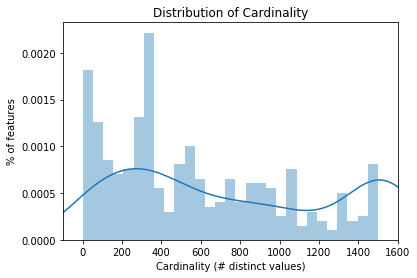

In [13]:
# count of unique values in each field
ax = sns.distplot(secom_df.nunique(), bins = np.linspace(0, 1500, 30));
ax.title.set_text('Distribution of Cardinality');
ax.set(xlabel='Cardinality (# distinct values)', ylabel='% of features')
ax.set_xlim(-100, 1600);

Store column names of features with only one (or two) unique values.

In [14]:
# store count of each values by column
unique_val_cnt = secom_df.nunique().tolist()

# identify columns with only 1 (redundant) or 2 (binary) unique values
null_cols = secom_df.columns[np.where(np.array(unique_val_cnt)==0)[0]]
redundant_cols = secom_df.columns[np.where(np.array(unique_val_cnt)==1)[0]]

After dealing with redundant (0 variance) columns, track the # of columns still left and the number removed.

In [15]:
# remove columns with only 1 unique value (redundant)
secom_df = secom_df.drop(redundant_cols, 1)
column_cnt_step3 = secom_df.shape[1]
print(column_cnt_step3, 'columns.', column_cnt_step2 - column_cnt_step3, 'columns removed.')

477 columns. 12 columns removed.


Examine nulls across the dataset.  Columns with all (or high) nulls could be problematic.

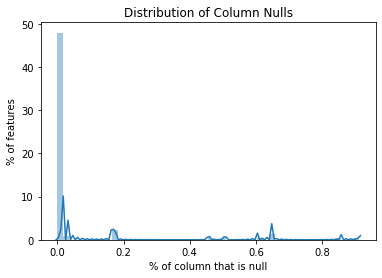

In [16]:
# pct of null values in each column
ax = sns.distplot(secom_df.isnull().sum() / secom_df.shape[0]);
ax.title.set_text('Distribution of Column Nulls');
ax.set(xlabel='% of column that is null', ylabel='% of features');

Columns that are over 80% null values we decide to drop. A more sophisticated approach might be to check whether the minimal information contained in these columns is indeed valuable to the model (e.g. by checking Mutual Information).

In this case, relatively few columns have *this* many null values and we still have many additional features left so we feel comfortable dropping them.

In [17]:
# store columns w >80% null values
high_null_cols = secom_df.T[(secom_df.isnull().sum() / secom_df.shape[0])>0.8].T.columns

In [18]:
# remove high null columns
secom_df = secom_df.drop(high_null_cols, 1)
column_cnt_step4 = secom_df.shape[1]
print(column_cnt_step4, 'columns.', column_cnt_step3 - column_cnt_step4, 'columns removed.')

469 columns. 8 columns removed.


Even though we dropped the columns with the *most* nulls, there are still many missing values that we need to handle.  Examining the distribution of remaining missing values shows this.

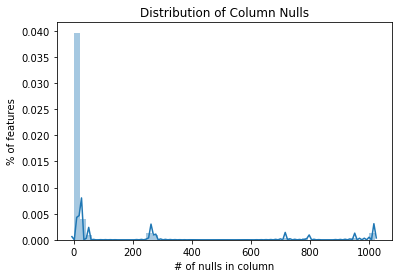

In [19]:
# store feature names in list
X_cols = secom_df.columns.difference(['target', 'date', 'time'], sort = False)

# nulls in each column (feature)
ax = sns.distplot(secom_df[X_cols].isnull().sum()); 
ax.title.set_text('Distribution of Column Nulls');
ax.set(xlabel='# of nulls in column', ylabel='% of features');

We also check missing values across columns to ensure that it's not just some rogue observations driving these missing values across columns.

It doesn't appear to be significantly so, although rows do rarely just have a single missing value (mode around 20 missing values per row).

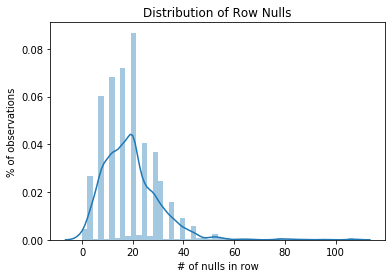

In [20]:
# nulls in each row (observation)
ax = sns.distplot(secom_df[X_cols].T.isnull().sum()); 
ax.title.set_text('Distribution of Row Nulls');
ax.set(xlabel='# of nulls in row', ylabel='% of observations');

Preview data for a few (arbitrary) rows with missing values.

In [21]:
# inspect a few arbitrary rows with missing values
index = secom_df[pd.to_numeric(secom_df[100], errors='coerce').isnull()].index
secom_df.iloc[index,:]

,0,1,2,3,4,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,43,44,45,46,47,48,50,51,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,86,87,88,89,90,91,92,93,94,95,96,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,142,143,144,145,146,147,148,150,151,152,153,154,155,156,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,180,181,182,183,184,185,187,188,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,221,222,223,224,225,227,228,238,239,244,245,246,247,248,249,250,251,252,253,254,255,267,268,269,270,271,272,273,274,275,277,278,279,280,281,282,283,285,286,287,288,289,290,291,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,316,317,318,319,320,321,323,324,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,359,360,361,362,363,365,366,367,368,376,377,382,383,384,385,386,387,388,389,390,391,392,393,405,406,407,408,409,410,411,412,413,415,416,417,418,419,420,421,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,452,453,454,455,456,457,459,460,467,468,469,470,471,472,473,474,475,476,477,478,479,480,482,483,484,485,486,487,488,489,490,491,493,494,495,496,497,499,500,510,511,516,517,518,519,520,521,522,523,524,525,526,527,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,target,date,time
700,3073.93,2472.68,2227.2444,1329.8933,0.9480,107.8778,0.1220,1.4443,0.0005,0.0022,0.9716,201.9615,9.7589,411.0656,10.2978,0.9762,191.6638,12.4859,1.3966,-5618.75,2998.75,-3996.25,1480.2500,0.9750,1.8725,5.0917,59.9667,2.8667,0.2209,4.6604,85.4507,9.3851,50.4554,63.8228,49.5446,65.7258,86.2213,118.5280,78.68,3.576,363.2227,9.8240,135.6645,738.9656,1.2241,138.0345,636.9218,226.0732,4.562,4.801,2915.0,0.9242,0.9502,4.4867,1.5527,359.7845,10.4604,117.2173,15.2109,18.4473,24.4248,714.5408,0.9362,144.7091,621.7109,116.3387,NaN,NaN,0.0,0.0130,-0.0594,0.0009,-0.0401,-0.0312,-0.0996,-0.0227,-0.0066,6.2299,0.1318,2.4334,0.9825,1843.9226,0.1958,9454.8601,NaN,0.0027,0.0003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.0106,0.0009,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.4574,0.9354,0.0,821.9768,0.9911,58.6073,0.6037,0.9752,6.1154,15.82,3.483,15.83,15.90,1.002,2.679,0.5642,3.106,0.7569,0.8057,0.9992,2.3391,1002.5790,38.1683,96.0,79.8,105.5,52.4001,389.0540,0.2677,4.36,0.0036,0.0950,0.0402,0.0435,0.0135,7.4839,4.220,5.550,0.3521,0.0092,7.2484,0.24,0.1153,671.0,587.0,566.0,145.0,0.088,0.071,0.118,2.9,1.1,0.096,0.156,0.3607,0.0731,0.3247,0.6595,0.3247,0.7643,0.2601,0.233,15.32,0.843,16.98,18.106,0.1692,7.62,14.53,74.048,0.100,6.43,20.17,0.504,12.66,12.78,6.43,6.000,19.302,0.0886,6.47,0.0,12.78,10.285,0.0,0.0699,0.0581,0.0344,0.0325,0.0267,0.1219,0.0627,0.0535,3.8510,0.0023,0.0405,0.0046,70.6064,0.0944,723.7002,0.0241,0.0120,0.0054,0.0039,NaN,NaN,NaN,0.0218,0.0213,0.0,78.3135,0.0011,1.6786,0.0297,0.0126,0.5584,0.0449,25.038,5.3886,19.2792,26.2983,35.4250,19.3647,112.6014,0.0826,1.5354,0.0011,0.0357,0.0125,0.0131,0.0045,2.2939,1.3037,1.8595,0.1029,0.0028,2.2251,0.0604,0.0320,286.2463,267.1908,280.8337,60.9993,0.0396,0.0298,0.0510,0.8958,0.3279,0.0278,0.0498,0.1427,0.0304,0.1335,0.2349,0.1335,0.2970,0.1044,0.0868,4.6827,0.2816,5.1320,5.1172,0.0616,2.5104,3.9783,21.6254,0.0272,2.0538,6.0769,0.1422,3.8507,8.5092,2.0538,1.9681,5.4973,0.0319,2.1962,0.0,3.8837,3.3393,NaN,NaN,0.0,0.0224,0.0281,0.0158,0.0136,0.0086,0.0598,0.0319,0.0252,1.4852,0.0007,0.0145,0.0013,23.2211,0.0252,281.2994,0.0050,0.0037,NaN,NaN,0.0018,0.0016,NaN,NaN,NaN,0.0062,0.0067,0.0,28.8584,0.0003,0.5398,0.0102,0.0043,0.1774,0.0143,9.0871,1.5339,4.3126,2.59

To deal with missing values we fit a multilple imputation estimator.  This will fill our missing values based on the conditional distribution of the other features (based on cases that are **not** null).  It does not use the target's conditional distribution (this is to avoid leakage).

Alternatives considered were mean or median filling, or zero-filling (assuming a missing sensor reading is equivalent to a value of 0).  Since we do not know the data well enough to know *why* the records are missing, we don't feel comfortable zero-filling.

Mean of median filling is generally a less accurate way to fill missing values since it does not take into accounts changes in the conditional distribution of the other features.

The downsides to using this estimator are additional processing time (60-90 seconds) and we would still suffer from biased imputations if the missing records are themselves biased in when they are missing.

In [22]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# limit to just 1 iteration (60-90 sec)
mice = IterativeImputer(max_iter=1, random_state=0) # initialize imputer
mice.fit(secom_df[X_cols]) # fit imputer

# make imputation
secom_df[X_cols] = mice.transform(secom_df[X_cols])

/opt/anaconda3/envs/uwdatasci400/lib/python3.6/site-packages/sklearn/impute/_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Again inspect the same arbitrary (previously missing) rows.  See they are now all filled with reasonable-ish looking values.

In [23]:
# inspect the same rows after imputation
secom_df.iloc[index,:]

,0,1,2,3,4,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,43,44,45,46,47,48,50,51,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,86,87,88,89,90,91,92,93,94,95,96,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,142,143,144,145,146,147,148,150,151,152,153,154,155,156,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,180,181,182,183,184,185,187,188,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,221,222,223,224,225,227,228,238,239,244,245,246,247,248,249,250,251,252,253,254,255,267,268,269,270,271,272,273,274,275,277,278,279,280,281,282,283,285,286,287,288,289,290,291,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,316,317,318,319,320,321,323,324,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,359,360,361,362,363,365,366,367,368,376,377,382,383,384,385,386,387,388,389,390,391,392,393,405,406,407,408,409,410,411,412,413,415,416,417,418,419,420,421,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,452,453,454,455,456,457,459,460,467,468,469,470,471,472,473,474,475,476,477,478,479,480,482,483,484,485,486,487,488,489,490,491,493,494,495,496,497,499,500,510,511,516,517,518,519,520,521,522,523,524,525,526,527,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,target,date,time
700,3073.93,2472.68,2227.2444,1329.8933,0.9480,107.8778,0.1220,1.4443,0.0005,0.0022,0.9716,201.9615,9.7589,411.0656,10.2978,0.9762,191.6638,12.4859,1.3966,-5618.75,2998.75,-3996.25,1480.2500,0.9750,1.8725,5.0917,59.9667,2.8667,0.2209,4.6604,85.4507,9.3851,50.4554,63.8228,49.5446,65.7258,86.2213,118.5280,78.680000,3.576000,363.2227,9.8240,135.6645,738.9656,1.2241,138.0345,636.9218,226.0732,4.562,4.801,2915.0,0.9242,0.9502,4.4867,1.5527,359.7845,10.4604,117.2173,15.2109,18.4473,24.4248,714.5408,0.9362,144.7091,621.7109,116.3387,153.690503,468.020395,0.0,0.0130,-0.0594,0.0009,-0.0401,-0.0312,-0.0996,-0.0227,-0.0066,6.2299,0.1318,2.4334,0.9825,1843.9226,0.1958,9454.8601,0.008815,0.002700,0.000300,-0.000037,0.000073,0.039136,0.008540,-0.012196,-0.000151,0.000035,0.006155,-0.010600,0.000900,-0.003043,0.000027,-0.041346,-0.044316,0.980631,101.812319,231.671017,0.457400,0.9354,0.0,821.9768,0.9911,58.6073,0.6037,0.9752,6.1154,15.82,3.483,15.83,15.90,1.002,2.679,0.5642,3.106,0.7569,0.8057,0.9992,2.3391,1002.5790,38.1683,96.0,79.8,105.5,52.4001,389.0540,0.2677,4.36,0.0036,0.0950,0.0402,0.0435,0.0135,7.4839,4.220,5.550,0.3521,0.0092,7.2484,0.24,0.1153,671.0,587.0,566.0,145.0,0.088,0.071,0.118,2.9,1.1,0.096,0.156,0.3607,0.0731,0.3247,0.6595,0.3247,0.7643,0.2601,0.233,15.32,0.843,16.98,18.106,0.1692,7.62,14.53,74.048,0.100,6.43,20.17,0.504,12.66,12.78,6.43,6.000,19.302,0.0886,6.47,0.0,12.78,10.285,0.0,0.0699,0.0581,0.0344,0.0325,0.0267,0.1219,0.0627,0.0535,3.8510,0.0023,0.0405,0.0046,70.6064,0.0944,723.7002,0.024100,0.012000,0.005400,0.003900,0.005803,1.764129,4.138987,0.021800,0.0213,0.0,78.3135,0.0011,1.6786,0.0297,0.0126,0.5584,0.0449,25.038,5.3886,19.2792,26.2983,35.4250,19.3647,112.6014,0.0826,1.5354,0.0011,0.0357,0.0125,0.0131,0.0045,2.2939,1.3037,1.8595,0.1029,0.0028,2.2251,0.0604,0.0320,286.2463,267.1908,280.8337,60.9993,0.0396,0.0298,0.0510,0.8958,0.3279,0.0278,0.0498,0.1427,0.0304,0.1335,0.2349,0.1335,0.2970,0.1044,0.0868,4.6827,0.2816,5.1320,5.1172,0.0616,2.5104,3.9783,21.6254,0.0272,2.0538,6.0769,0.1422,3.8507,8.5092,2.0538,1.9681,5.4973,0.0319,2.1962,0.0,3.8837,3.3393,6.003583,5.471159,0.0,0.0224,0.0281,0.0158,0.0136,0.0086,0.0598,0.0319,0.0252,1.4852,0.0007,0.0145,0.0013,23.2211,0

And lastly, also verify no features have missing values after imputation.

In [24]:
# no remaining nulls
secom_df.isnull().sum().value_counts()

0    469
dtype: int64

## Class imbalance

- `target =  1` (failure)
- `target = -1` (success)

First, let's check class balance.  We do see that our data are heavily biased toward successes (`target = -1`).  Only \~100 rows (~7%) are failures.

In [25]:
print("{:.2%}".format((secom_df['target']==1).mean()), 'of values')
print(secom_df['target'].value_counts())

6.64% of values
-1    1463
 1     104
Name: target, dtype: int64


Before moving forward, drop the `date` and `time` labels as we won't be using them as features and they complicate oversampling.

In [26]:
# drop unneeded timestamp data from labels
secom_df = secom_df.drop(['date', 'time'], axis = 1)

To address class imbalance, we will use smote (**S**ynthetic **M**inority **O**versampling **TE**chnique) to interpolate our X features based on positive cases (where `target = 1`). 

Since smote is based on a knn algorithm, we'll first standardize our features.  knn is strongly influenced by varying magnitudes across features since it is a distance based algorithm.

In [27]:
from sklearn.preprocessing import StandardScaler

# initialize and fit z-transform on features
znormalizer = StandardScaler()
znormalizer.fit(secom_df[X_cols])

# apply fitted transformation to features
X_norm = pd.DataFrame(znormalizer.transform(secom_df[X_cols]), columns = X_cols)

Now we'll implement smote to balance our target variable.

In [28]:
from imblearn.over_sampling import SMOTE

# initialize SMOTE and resample the minority class (y=1)
smote = SMOTE(random_state=0)
X_smote, y_smote = smote.fit_resample(X = X_norm, y = secom_df['target'])

Inspecting target counts now shows balanced classes.

In [29]:
y_smote.value_counts()

 1    1463
-1    1463
Name: target, dtype: int64

## feature selection

We use 3 feature selection techniques to reduce the dimensionality of our data.
- filter (Mutual Information)
- wrapper (Forward Selection)
- embed (Lasso Regression)

### Mutual information

Start by calculating mutual information of each remaining attribute with the target (on our class-balanced dataset).

In [30]:
# calculate mutual information w target
mi_score = mutual_info_regression(X_smote, y_smote, random_state=0)
mi_score_df = pd.DataFrame({'attribute': X_smote.columns, 'mi_score': mi_score})

Sort the dataframe by M.I. score for nicer looking plotting...

In [31]:
# sort by mutual information for bar plot
mi_score_df = pd.DataFrame(mi_score_df.sort_values(
    by = 'mi_score',
    ascending = False
))

Define a function that will nicely show the Mutual Information for each feature.

In [32]:
def plot_mi(df, x, y):
    # set figure size
    fig = plt.figure(figsize=(20,6))

    # define barplot (sorted descending)
    ax = sns.barplot(x=x, 
                     y=y,
                     data = df,
                     order = df[x],
                     palette="Blues_d")

    # make axis as readable as possible
    ax.title.set_text('Mutual Information by attribute');
    ax.set(xlabel='Attributes', ylabel='Mutual Information')
    ax.set(xticklabels=[])

Mutual information levels off around 0.3 for many features before dropping off again.  It doesn't level off until around 0.1 after that.

We'll start by drawing two thresholds, which we'll choose from based on the results of our feature reduction techniques.

1. `MI > 0.3` for features with "high" mutual information
2. `MI > 0.1` for features with "medium" mutual information

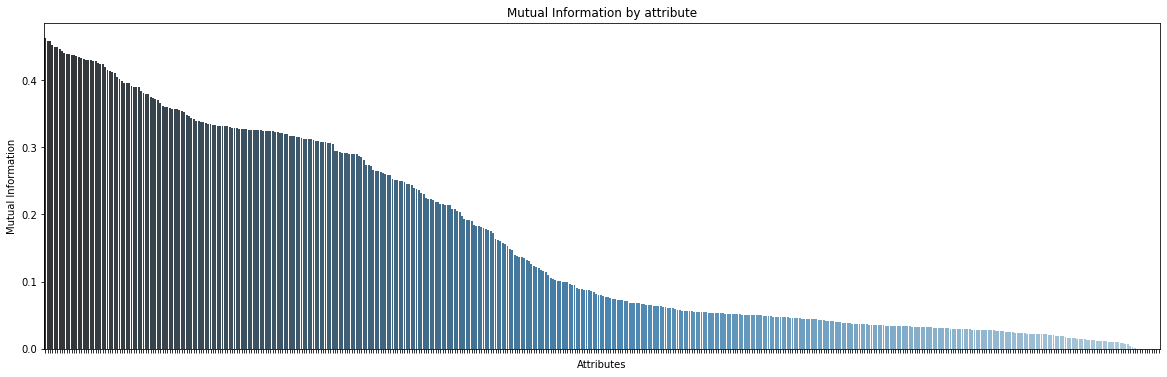

In [33]:
# plot MI of all features with target
plot_mi(mi_score_df, 'attribute', 'mi_score')

Store qualfying features (based on above thresholds) into lists and print out how many of each.

The lower threshold keeps ~100 features that the higher threshold ignored.

In [34]:
# keep only features with M.I. GT 0.2 with target
high_mi_df = mi_score_df[mi_score_df['mi_score']>0.3]
mid_mi_df = mi_score_df[mi_score_df['mi_score']>0.1]

high_mi_cols = high_mi_df['attribute'].tolist()
mid_mi_cols = mid_mi_df['attribute'].tolist()

print('# of feature with high MI:', len(high_mi_cols))
print('# of feature with medm MI:', len(mid_mi_cols))

# of feature with high MI: 121
# of feature with medm MI: 216


Since some of the features above may be highly correlated with each other, we also take the additional step to remove a degree of that dependence.  Independent features is a key assumption for linear models (which we may be interested in using at a later time).

We define a function that takes a df (of features) and calculates the correlation of each combination.  If it's above a certain threshold (0.7), it stores *one* of those columns in a list for removal (not both).

In [35]:
def find_corr_features(df):

    corr_cols = []

    # check for MI within remaining features
    for col_i in df.columns:
        for col_j in df.columns:

            # compute MI for upper triangle
            if col_i < col_j:
                corr = df[col_i].corr(df[col_j]) 
                
                # store & print if above threshold
                if corr > 0.7:
                    corr_cols.append(col_i)

    return corr_cols

Apply this function to the high and medium M.I. features we identified earlier and to store a list of the features that we will drop.

In each case (high, medium), this step removes almost half of the remaining features.

In [36]:
# store columns with high correlation between each other
high_mi_corr_cols = find_corr_features(X_smote[high_mi_cols])
mid_mi_corr_cols = find_corr_features(X_smote[mid_mi_cols])

# remove duplicates from drop_cols list
high_mi_corr_cols = list(dict.fromkeys(high_mi_corr_cols))
mid_mi_corr_cols = list(dict.fromkeys(mid_mi_corr_cols))

print('# of features to drop from high MI:', len(high_mi_corr_cols))
print('# of features to drop from medm MI:', len(mid_mi_corr_cols))

# of features to drop from high MI: 47
# of features to drop from medm MI: 92


Keep only features with low dependence on one another.

In [37]:
# keep only the features with low dependence on one another
high_mi_cols = X_smote[high_mi_cols].columns.difference(high_mi_corr_cols, sort = False)
mid_mi_cols = X_smote[mid_mi_cols].columns.difference(mid_mi_corr_cols, sort = False)

print('# of low dependence features with high MI on target:', len(high_mi_cols))
print('# of low dependence features with medm MI on target:', len(mid_mi_cols))

# of low dependence features with high MI on target: 74
# of low dependence features with medm MI on target: 124


Plot of the Mutual Information once more of the remaining features to see what we're left with.

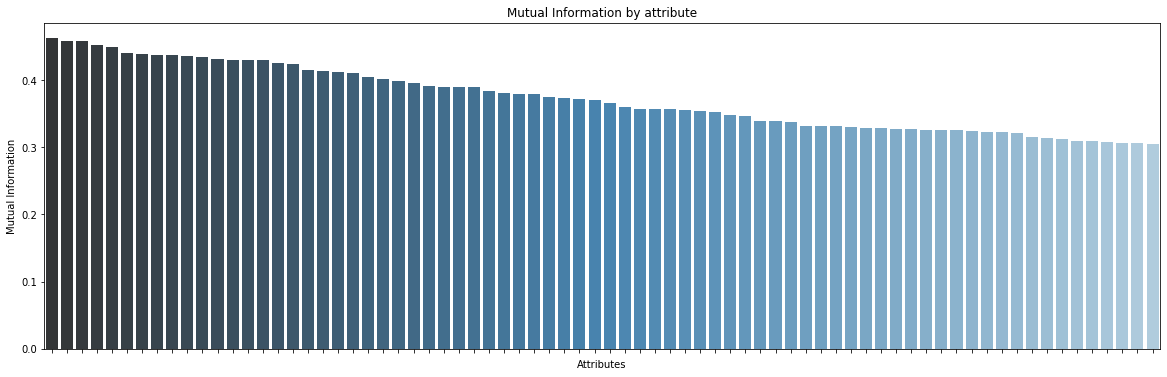

In [38]:
# plot remaining high MI features
plot_mi(mi_score_df[mi_score_df['attribute'].isin(high_mi_cols)],
        'attribute',
        'mi_score'
)

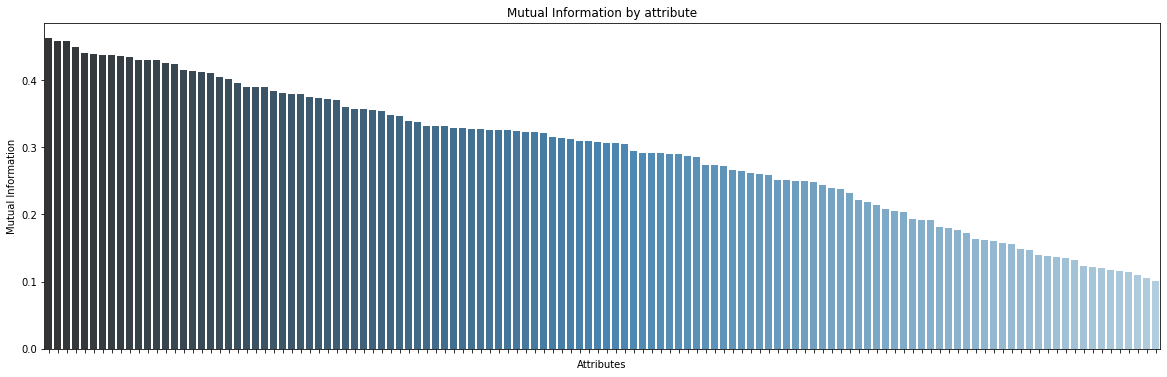

In [39]:
# plot remaining medium MI features
plot_mi(mi_score_df[mi_score_df['attribute'].isin(mid_mi_cols)],
        'attribute',
        'mi_score'
)

### Forward selection

We use forward selection, continually adding one feature to a linear model and monitoring when to stop (based on error).  Normally, we create a model stepping through every feature in our data, but given processing constraints we'll limit our testing here.

Based on the # of relevant features found in the filtering method above, we feel comfortable stopping after 200 steps.  This should be more than enough to see when diminishing marginal returns set in.

We'll also use two-fold crossvalidation, because without cross-validation, the algorithm is extremely susceptible to overfitting.  More than two folds and the already long run-time (~15 minutes) gets a bit too burdensome.

In [40]:
# initilize our estimator (w lin. reg. algorithm)
estimator = LinearRegression()

# specify stepwise params
stepwise_selector = SFS(estimator, 
    k_features = 200, # stop after 200 steps
    forward = True, 
    scoring = 'neg_mean_squared_error', # for regression
    cv = 2  # just use 2 folds to limit processing time
    )

### *NOTE: Fitting the selector took about ~15 minutes to run*

In [41]:
# train selector
stepwise_selector = stepwise_selector.fit(X_smote, y_smote)

### Find the best model.

The best step will be the one with the lowest abs. error. Since we used negative MSE, this means the highest score (the score closest to 0).

Since we specified a `k_features` value (rather than using "parsimonious") we take this extra step to identify the best step.

In [42]:
# set default values
best_step = 0
error = -999999

# loop through step scores to find best step
for i in stepwise_selector.get_metric_dict():
    i_error = stepwise_selector.get_metric_dict()[i]['avg_score']
    if i_error > error:
        best_step = i
        error = i_error

In [43]:
# store info on best step
# best_step = best_selector.shape[1] # nbr of features in best step
best_step_metrics = stepwise_selector.get_metric_dict()[best_step] # store dict of best model
best_step_features = list(best_step_metrics['feature_names']) # access dict: feature names

# show best model step & features
print('feature cnt:', best_step)
# best_step_features

feature cnt: 117


Plotting the step results below shows that the model starts doing noticeably worse as it approaches 200 steps.  Diminishing marginal returns also are realized relatively quickly as features were added to the model.

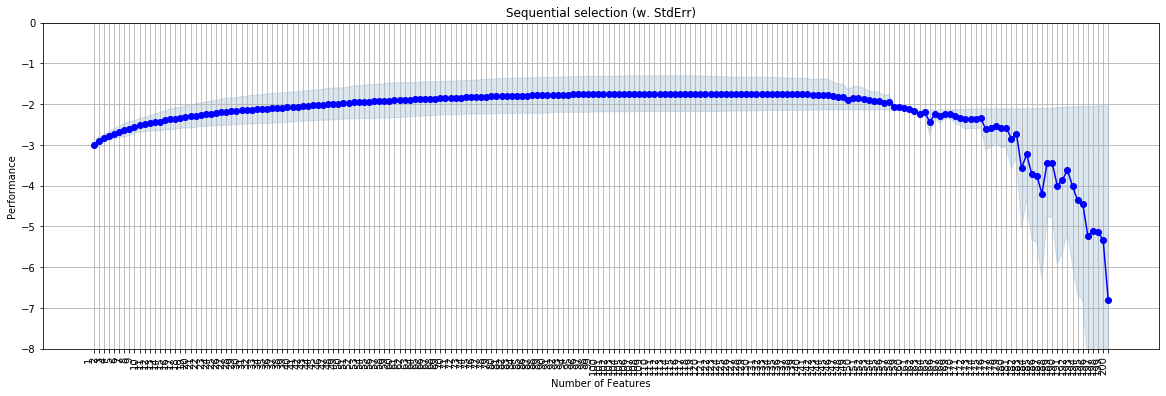

In [44]:
# define plot
(fig, ax) = plot_sfs(stepwise_selector.get_metric_dict(), kind = 'std_err', figsize=(20, 6))

# set labels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, horizontalalignment='right');
ax.set_ylim(-8, 0);
plt.title('Sequential selection (w. StdErr)')
plt.grid()
plt.show()

### Lasso Regression

Lasso Regression adds a penalty term based on the absolute value of the coefficients on each feature.  As the penalty term gets bigger, more & more of the features used have their coefficients shrink to 0.

Almost immediately (alpha = 0.01), the # of features gets cut in half.  Around alpha = 0.025 the # of features starts to hit an inflection point.  Not until about alpha = 0.1 does the # of features remaining begin to stabilize a bit.

Since we're performing regularization, we'll need to split into test & train to see the effect of the hyper parameter (alpha).

In [45]:
# split into train/test for regularization
x_train, x_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.20)

Run Lasso Regression once for each value of alpha and store the coefficients.

In [46]:
# seq of penalty values ('alphas') to try
alphas = np.linspace(0.0001, 0.15, 49)
num_coefs = x_train.shape[1]

# Store coefficients for each alpha:
coef_cols = [i for i in x_train.columns] + ['intercept']
alpha_df = pd.DataFrame(columns=coef_cols)

for a in alphas:
    # Fit model
    clf_temp = linear_model.Lasso(alpha=a, tol=0.1)
    clf_temp.fit(x_train, y_train)
    # Get coefficients + intercept
    coef_nums = np.append(clf_temp.coef_, clf_temp.intercept_)

    alpha_df = alpha_df.append(dict(zip(coef_cols, coef_nums)), ignore_index=True)

# set index values to penalty terms
alpha_df.index = alphas

Take a look at the model coefficients.

In [47]:
alpha_df.head() # preview model coefficients

,0,1,2,3,4,6,7,8,9,10,11,12,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,43,44,45,46,47,48,50,51,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,86,87,88,89,90,91,92,93,94,95,96,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,142,143,144,145,146,147,148,150,151,152,153,154,155,156,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,180,181,182,183,184,185,187,188,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,221,222,223,224,225,227,228,238,239,244,245,246,247,248,249,250,251,252,253,254,255,267,268,269,270,271,272,273,274,275,277,278,279,280,281,282,283,285,286,287,288,289,290,291,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,316,317,318,319,320,321,323,324,331,332,333,334,335,336,337,338,339,340,341,342,343,344,345,346,347,348,349,350,351,352,353,354,355,356,357,359,360,361,362,363,365,366,367,368,376,377,382,383,384,385,386,387,388,389,390,391,392,393,405,406,407,408,409,410,411,412,413,415,416,417,418,419,420,421,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,452,453,454,455,456,457,459,460,467,468,469,470,471,472,473,474,475,476,477,478,479,480,482,483,484,485,486,487,488,489,490,491,493,494,495,496,497,499,500,510,511,516,517,518,519,520,521,522,523,524,525,526,527,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,intercept
0.000100,-0.010905,-0.015211,-0.035006,-0.079259,0.229989,-0.088796,-0.007411,-0.05109,-0.048796,-0.054753,0.082740,0.129076,0.093166,-0.055704,0.398640,-0.093670,-0.100355,0.050000,0.036535,0.056281,0.070740,-0.004757,-0.027420,0.535008,-0.399727,-0.082473,-0.032056,0.085965,-0.143658,0.132292,0.119265,0.022782,0.000733,-0.042785,-0.000492,-0.043762,0.007787,-0.083892,-0.076528,-0.048429,0.278781,0.084656,0.339372,-0.252401,-0.106322,-0.014574,0.312177,0.065016,-0.337859,0.000000,-0.045246,0.414074,0.000637,0.104669,0.397850,0.012803,0.086736,-0.224212,0.270608,0.506656,-0.452998,-0.109129,-0.593773,-0.214909,0.220687,0.132267,0.06791,-0.001160,0.0,0.031838,0.020304,0.056936,-0.046836,0.019636,-0.033349,0.037649,0.019571,0.085142,0.063081,0.032330,0.064062,0.044699,0.089989,0.075520,-0.025221,-0.432186,0.345561,-0.119993,-0.023758,0.140732,0.233028,0.185558,0.154129,-0.034168,-0.038554,-0.020195,0.117808,-0.411701,0.376186,0.053539,-0.060489,-0.644689,0.000292,0.025303,0.021986,0.009307,-0.075969,-0.095164,0.016624,-0.430947,-0.036065,-0.031578,-0.002359,0.125249,-0.126278,-0.043548,-0.135059,0.085400,0.015011,-0.050397,-0.030158,0.132304,0.054980,0.081964,-0.215462,0.020931,-0.083329,0.031624,0.2228,0.112228,0.279508,0.079354,0.0,0.065793,-1.067433,0.386605,-0.005074,0.053813,-0.273486,-0.168419,-0.176664,-0.141365,-0.106262,-0.080812,0.157412,-0.408035,-0.32895,-0.170643,-0.003960,-0.834535,0.088039,-0.103171,-0.229154,0.080488,0.136387,-0.103101,0.158875,-0.040317,-0.082854,-0.37578,0.109488,-0.139844,0.077326,-0.009742,0.01021,0.155012,0.097304,-0.138035,0.274722,-0.257303,0.718824,-0.964883,0.008244,0.120006,0.096805,0.143114,0.236737,0.492346,-0.270818,-0.137109,-0.452620,0.252093,0.360821,-0.123160,0.053725,0.0,0.181000,-0.02494,0.0,-0.133165,-0.162007,-0.151337,0.071334,-0.158433,-0.027750,0.230117,-0.150736,-0.233829,-0.786449,-0.088857,-0.069013,-0.037342,-0.161969,0.433054,-0.133235,0.170115,0.109086,0.179899,-0.071052,-0.091043,0.000114,0.206802,-0.034956,0.202405,-0.535412,-0.021725,0.550594,0.192857,0.149532,0.060068,0.033925,-0.000000,0.420384,0.112193,0.052538,-0.182031,-0.102184,0.042136,-0.0,0.464431,0.077261,-0.089663,-0.073955,-0.108310,0.610376,-0.717227,-0.0,-0.0,-

Visually see how as the penalty term increases, more & more of the coefficients drop to 0.  We see almost immediately **a lot** of the features drop to 0.

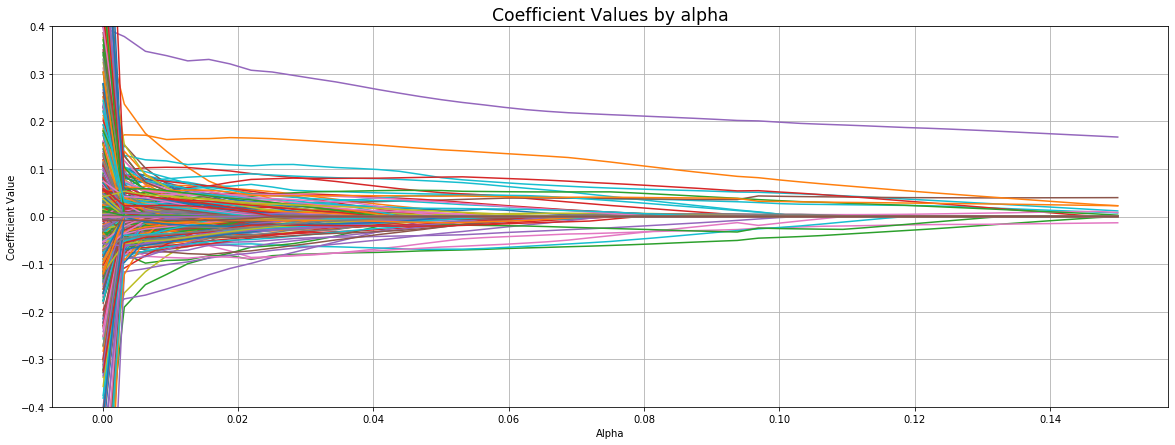

In [48]:
# exclude intercept from polot
coef_cols = alpha_df.columns.difference(['intercept'], sort = False)

ax = alpha_df[coef_cols].plot.line(legend=None, grid=True, figsize=(20, 7))
ax.title.set_text('Coefficient Values by alpha');
ax.title.set_size('xx-large');
ax.set(xlabel='Alpha', ylabel='Coefficient Value');
ax.set_ylim(-0.4, 0.4);

To more easily see when exactly features fall out of the model, we'll plot it directly.  We'll choose where to set our threshold for feature reduction based on where we see the inflection point as well as what we expect from our other feature selection methods above.

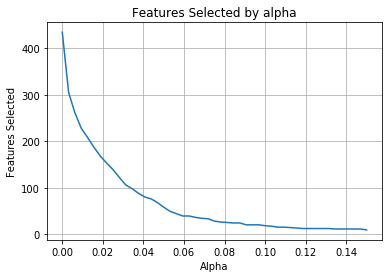

In [49]:
ax = sns.lineplot(
    x=alpha_df.index, 
    y=np.count_nonzero(alpha_df[coef_cols], axis=1)
    )
ax.title.set_text('Features Selected by alpha');
ax.set(xlabel='Alpha', ylabel='Features Selected');
plt.grid();

Add a column to store the number of selected features (i.e. the # of non-zero features).  Then select just the row at alpha ~= 0.025 where the # of features ~= 100.

Note: There is surely a better way to do this, but indexing wasn't working.

In [79]:
alpha_df['non_zero'] = np.count_nonzero(alpha_df[coef_cols], axis=1)
lasso_row_df = alpha_df[(alpha_df['non_zero']>100) & (alpha_df['non_zero']<115)]

Store the feature names with non-zero coefficients at our chosen threshold

In [80]:
lasso_cols = list(lasso_row_df.columns[(lasso_row_df != 0).iloc[0]])

# remove the last two columns from the list
del lasso_cols[-1]
del lasso_cols[-1]

# lasso_cols

### Combining the Feature Selection Methods

Using the above techniques, we'll settle on which features to keep going forward.

Convert the Mutual information objects from before to lists

In [81]:
high_mi_cols = list(high_mi_cols)
mid_mi_cols = list(mid_mi_cols)

Examine the # of features kept using each method.  The "high" mutual information threshold seems to have been a bit stricter than the other methods (fewer features kept), so we'll use the the "medium" mutual information threshold list instead.

We'll search for overlap in features selected across each of these methods.  Individually, each method kept around, or slightly over, 100 features.

In [82]:
print('# of features identified by high mutual information:', len(high_mi_cols))
print('# of features identified by medm mutual information:', len(mid_mi_cols))
print('# of features identified by best stepwise selector :', len(best_step_features))
print('# of features identified by lasso regression       :', len(lasso_cols))

# of features identified by high mutual information: 74
# of features identified by medm mutual information: 124
# of features identified by best stepwise selector : 117
# of features identified by lasso regression       : 106


Now combine the feature selections from each method and examine their intersection.

In [83]:
from collections import Counter

# combine selected features into large list (with dupes)
features_list = mid_mi_cols + best_step_features + lasso_cols

# apply counter to count # of occurences of each feature (while de-duping)
feature_cnt_dict = Counter(features_list)
feature_cnt_df = pd.DataFrame.from_dict(feature_cnt_dict, orient='index').reset_index()

It looks like there are about 250 unique features selected by these different methods. About 80 of them appeared in **at least** two of the three methods, so we will keep those.

In [84]:
feature_cnt_df[0].value_counts()

1    177
2     64
3     14
Name: 0, dtype: int64

Here we take the final step of storing our 'feature to keep' in a list for use in future modeling.

In [85]:
keep_features = list(feature_cnt_df['index'][feature_cnt_df[0]>1])
print('# of reduced features for modeling:', len(keep_features))

# of reduced features for modeling: 78


## Findings

There are a lot of decisions to make in the feature reduction process.

I was surprised at how many columns could be eliminiated without applying any feature selection methods at all.  Simply through data cleaning, we were able to eliminate over 100 columns.

Also surprising was the relatively minimal intersection of the features selected using each method.  I was surpised that almost 2/3 of the unique features selected across the methods were actually *only* selected by 1 method.

In the end we were able to reduce dimensionality to about 80 features, much less than the nearly 600 we started with!